In [1]:
from hyp_solver3 import HypProblem, Mesh, Solver
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]
# C = [2.3,0.9]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))


G11 = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G12 = lambda t: - G11(t)
G21 = lambda t: (np.sin(t)) / (np.cos(t) - 4* np.sin(t))
G22 = lambda t: - G21(t)

F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0

phi_dx = lambda s, x, y : -2*(x - x_an(s, T[1])) 
phi_dy = lambda s, x, y : -2*(y - y_an(s, T[1]))

hyp_problem = HypProblem(T=T, S=S, C=C, B=[[B11, B12], [B21, B22]], 
                         F=[F1, F2], G=[[G11, G12], [G21, G22]], 
                         X0=x0, Y0=y0, phi_dx=phi_dx, phi_dy=phi_dy)

mesh = Mesh(hyp_problem, 70)
solver = Solver()

In [3]:
def plot_final(mesh):
    nodes = mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    plt.subplot(2, 1, 1)
    plt.plot(s, x, "ro")
    plt.plot(s, [x_an(si, T[1]) for si in s], "b-")
    plt.ylabel("x")
    plt.subplot(2, 1, 2)
    plt.plot(s, y, "ro")
    plt.plot(s, [y_an(si, T[1]) for si in s], "b-")
    plt.ylabel("y")

    deltas_x = [abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)]
    deltas_y = [abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)]
        
    print(f"dx:{np.max(deltas_x)}\ndy:{np.max(deltas_y)}")


def plot_left(mesh):
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    print(y)
    plt.subplot(2, 1, 1)
    plt.plot(t, x, "ro")
    plt.plot(t, [x_an(S[0], ti) for ti in t], "b-")
    plt.ylabel("x")
    plt.subplot(2, 1, 2)
    plt.plot(t, y, "ro")
    plt.plot(t, [y_an(S[0], ti) for ti in t], "b-")
    plt.ylabel("y")

    deltas_x = [abs(xi-x_an(S[0],ti)) for ti, xi in zip(t, x)]
    deltas_y = [abs(yi-y_an(S[0],ti)) for ti, yi in zip(t, y)]
        
    print(f"dx:{np.max(deltas_x)}\ndy:{np.max(deltas_y)}")


def plot_v(mesh, hyp_problem):
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    v_true = [G22_true(ti) for ti in t]
    v = [hyp_problem.G22(ti) for ti in t]
    
    plt.plot(t, v, "ro")
    plt.plot(t, v_true, "b-")
    plt.legend(["v", "v_an"])
    plt.ylabel("v")

In [4]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: G22_true(t)+1
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)



dx:0.00014232570046113224
dy:0.0670163709640269


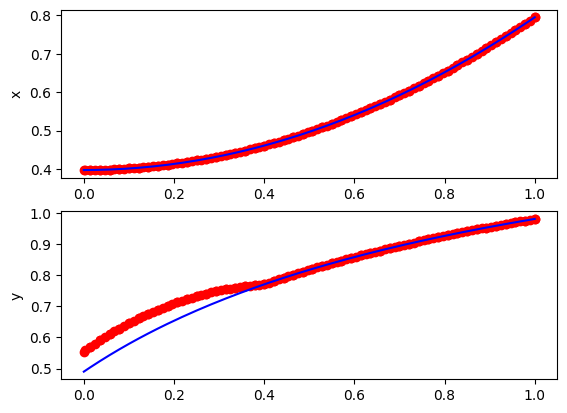

In [5]:
plot_final(mesh)

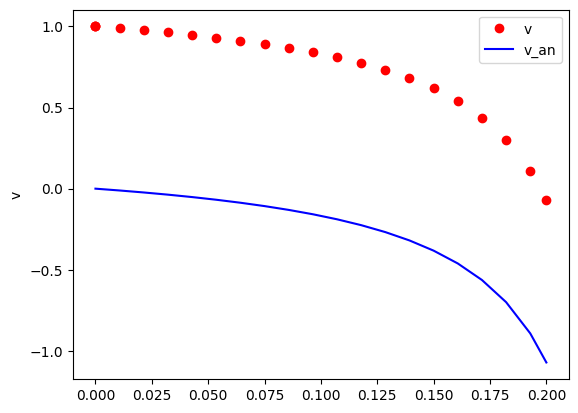

In [6]:
plot_v(mesh, hyp_problem)

In [7]:
nodes = mesh.get_border(type_border="left", sort_t=True)
t_mesh = [node[0][3] for node in nodes]
t_index = []
t_hash = []
for i, e in enumerate(t_mesh):
    if not e in t_hash:
        t_hash.append(e)
        t_index.append(i)


def model(v):
    v_ = [v[ti] for ti in t_index]
    G22_0 = lambda ti: np.interp(ti, t_hash, v_)
    G21_0 = lambda ti:  - G22_0(ti)
    hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])
    
    solver.solve_initial(mesh, hyp_problem)
    solver.solver_center(mesh, hyp_problem)
    solver.solver_final(mesh, hyp_problem)

    nodes = mesh.get_border(type_border="final", sort_s=True)
    s_final = [node[0][2] for i, node in enumerate(nodes) if i in t_index]
    x_final = [node[1][0][0] for i, node in enumerate(nodes)if i in t_index]
    y_final = [node[1][0][1] for i, node in enumerate(nodes) if i in t_index]

    f = [(xi-x_an(si, T[1]))**2+(yi-y_an(si, T[1]))**2 for xi, yi, si in zip(x_final, y_final, s_final)]
    return scipy.integrate.trapezoid(f, s_final)


def get_resid(t_h, h_u_k, uk_new, uk):
    f = [h*(uk_new_i-uk_i) for h, uk_new_i, uk_i in zip(h_u_k, uk_new, uk) ]
    return scipy.integrate.trapezoid(f, t_h) 

def get_uki(a, uk, uk_new):
    return [ uk_i + a*(uk_new_i - uk_i) for uk_i, uk_new_i in zip(uk, uk_new)]


ALPHA_HYSTORY = 0
def alpha_test(mesh, t_h, uk, uk_new):
    global ALPHA_HYSTORY
    # ALPHA_HYSTORY = 0
    is_run = True
    is_run_2 = False
    J_old = model(uk)
    a = 2/(2+ALPHA_HYSTORY)
    # a = 0.01
    max_a = ALPHA_HYSTORY + 100
    while is_run:
        uk_a = get_uki(a, uk, uk_new)
        J_new = model(uk_a)
        if is_run_2 and J_old < J_new:
            return a
        if J_old > J_new:
            J_old = J_new
            is_run_2 = True
        ALPHA_HYSTORY += 1
        a =  2/(2+ALPHA_HYSTORY)
        # a += 0.009
        if ALPHA_HYSTORY > max_a:
            print("min alpha")
            return a


eps = 0.00001
u0 = -2.5
u1 = 1.0
DREZ = []
Nodes = []
G = []
for k in range(1, 20):
    solver.solve_initial(mesh, hyp_problem)
    solver.solver_center(mesh, hyp_problem)
    solver.solver_final(mesh, hyp_problem)
    solver.solver_initial_conj(mesh, hyp_problem)
    solver.solver_center_conj(mesh, hyp_problem)
    solver.solver_final_conj(mesh, hyp_problem)
    
    # -----------------------------------------------------
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    
    hu = [node[1][1][2]*(node[1][0][0]-node[1][0][1]) for node in nodes]
    
    uk = [hyp_problem.G22(ti) for ti in t]
    new_uk = []
    for uki, hui in zip(uk, hu):
        if hui == 0:
            new_uk.append(uki)
        elif hui > 0:
            new_uk.append(u1)
        else:
            new_uk.append(u0)
    

    drez = get_resid(t, hu, new_uk, uk) 
    DREZ.append(drez)
    
    print("Оптимально" if drez <= eps else "Не оптимально")
    print(f"Невязка составляет: {drez:.6f}")
    if drez <= eps:
        print(f"Невязка составляет: {drez:.6f}")
        print( f"Решено на {k}-й итерации")
        break
    print(40*"*")    
    a = alpha_test(mesh, t, uk, new_uk) 
    uk_a_min = get_uki(a, uk, new_uk)
    
    G22_0 = lambda ti: np.interp(ti, t, uk_a_min)
    G21_0 = lambda ti:  - G22_0(ti)

    G.append([hyp_problem.G22(ti) for ti in t])
    Nodes.append(nodes)
    
    print("результат минимизации a = ", a)
    hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

Не оптимально
Невязка составляет: 0.007022
****************************************
результат минимизации a =  0.25
Не оптимально
Невязка составляет: 0.000729
****************************************
результат минимизации a =  0.06060606060606061
Не оптимально
Невязка составляет: 0.000017
****************************************
min alpha
результат минимизации a =  0.014925373134328358
Не оптимально
Невязка составляет: 0.000016
****************************************
min alpha
результат минимизации a =  0.00851063829787234
Не оптимально
Невязка составляет: 0.000024
****************************************
результат минимизации a =  0.006172839506172839
Не оптимально
Невязка составляет: 0.000011
****************************************
min alpha
результат минимизации a =  0.004705882352941176
Оптимально
Невязка составляет: 0.000007
Невязка составляет: 0.000007
Решено на 7-й итерации


dx:1.2002274732914042e-05
dy:0.0009201893082272372


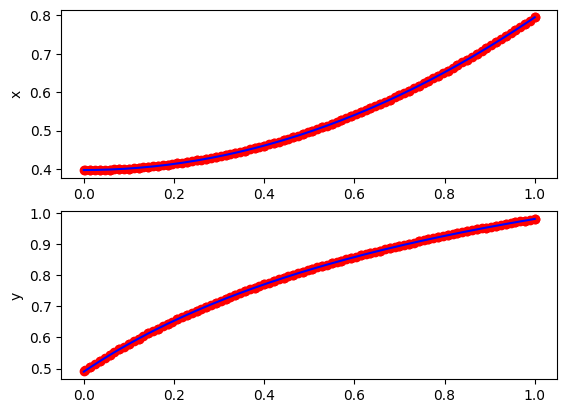

In [8]:
plot_final(mesh)

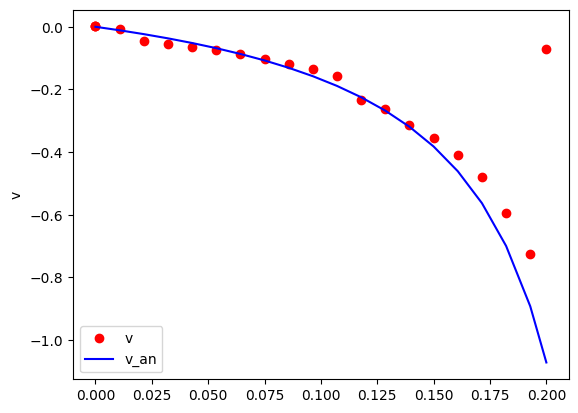

In [9]:
plot_v(mesh, hyp_problem)

[0.5, 0.5, 0.5, 0.4999855553975616, 0.4998596795996937, 0.49962583370275493, 0.49935958923068463, 0.4990609767976312, 0.4987299919920671, 0.4983667203659162, 0.49797115012852533, 0.4975432484545577, 0.49708309120574556, 0.4965189611166997, 0.4958569949743428, 0.4951557598648837, 0.494417333927739, 0.49366271109250165, 0.49289163700256333, 0.4920890278845593, 0.4912568806685849, 0.49095347822884805]
dx:1.2002274732914042e-05
dy:0.0009201893082272372


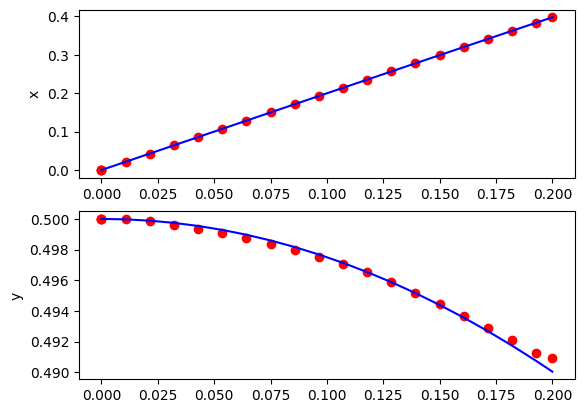

In [10]:
plot_left(mesh)